In [1]:
using LinearAlgebra
using Printf
using Plots

cd("..")
using Pkg
Pkg.activate(".")
using SBP_operators

  Activating project at `c:\Users\darea\Documents\Git-stuff\SBP_operators`


In [54]:
function innerH(u::Matrix{Float64},Hx::Vector{Float64},Hy::Vector{Float64},v::Matrix{Float64})
    ny,nx = size(u)
    tmp = 0
    for i = 1:nx
        for j = 1:ny
            tmp += u[i,j]*v[i,j]*Hx[i]*Hy[j]
        end
    end
    return tmp
end

function A(uⱼ,PDE::Function,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y;order=2)
    u = zeros(size(uⱼ))
    return uⱼ - Δt*PDE(u,uⱼ,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order)
end

function cg(b,uⱼ,PDE,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,Hx,Hy;order=2,tol=1e-5,maxIT=10)
    xₖ = zeros(size(b))
    rₖ = A(uⱼ,PDE,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order) - b
    dₖ = -rₖ
    i = 0
    rnorm = sqrt(innerH(rₖ,Hx,Hy,rₖ))
    while (rnorm>tol) & (i < maxIT)
        Adₖ = A(dₖ,PDE,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order)
        dₖAdₖ = innerH(dₖ,Hx,Hy,Adₖ)
        αₖ = -innerH(rₖ,Hx,Hy,dₖ)/dₖAdₖ
        xₖ = xₖ + αₖ*dₖ
        rₖ = A(xₖ,PDE,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order) - b
        βₖ = innerH(rₖ,Hx,Hy,A(rₖ,PDE,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order))/dₖAdₖ
        dₖ = - rₖ + βₖ*dₖ
        rnorm = sqrt(innerH(rₖ,Hx,Hy,rₖ))
        i += 1
    end
    if rnorm > tol
        print("CG did not converge at time ",t)
    end
    return xₖ
end


cg (generic function with 4 methods)

In [55]:
function time_solver(soln,RHS,nx,ny,Δx,Δy,x,y,Δt,k,boundary_x,boundary_y;method=:euler,order=2,maxIT=5)

    N = ceil(Int64,t_f/Δt)

    tol = 1e-5
    # maxIT = 5
    err = 1.
    # α = 1.5 * Δt
    α = 1e-2
    
    if method == :euler
        for i = 1:N-1
            t = i*Δt
            u[:,:,i+1] = u[:,:,i] + Δt*RHS(u[:,:,i+1],u[:,:,i],nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order)
        end
    elseif method == :impliciteuler
        for i = 1:N-1
            t = i*Δt
            uⱼ = u[:,:,i]
            j = 0
            # err = 1.
            while (j < maxIT) & (err > tol)
                f = (uⱼ - u[:,:,i] - Δt*RHS(u[:,:,i+1],u[:,:,i],nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order))
                uⱼ = uⱼ - α * f
                err = norm(f)
                j += 1
                # print(j)
            end
            u[:,:,i+1] = u[:,:,i] + Δt * RHS(u[:,:,i+1],uⱼ,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,order=order)
            if err > tol
                println("Predictor did not converge, error: ",err)
            end
        end
    elseif method == :cgie
        if order == 2
            Hx = ones(nx)
            Hx[1] = Hx[end] = 0.5
            Hy = ones(ny)
            Hy[1] = Hy[end] = 0.5
        elseif order == 4
            H = diagm(ones(length(u)))
            H[1,1] = H[end,end] = 0.5
            H[2,2] = H[end-1,end-1] = 0.5
            H[3,3] = H[end-2,end-2] = 0.5
        elseif order == 6
            H = diagm(ones(length(u)))
        end
        Hx = Δx*Hx
        Hy = Δy*Hy
        for i = 1:N-1
            t = i*Δt
            uⱼ = u[:,:,i]
            u[:,:,i+1] = cg(uⱼ,uⱼ,RHS,nx,ny,Δx,x,Δy,y,Δt,t,k,boundary_x,boundary_y,Hx,Hy;order=2,tol=1e-5,maxIT=20)
        end
    else
        error("spell things right")
    end


    return soln
end

time_solver (generic function with 1 method)

# 2D ADE

$$
\begin{align}
    \frac{\partial u}{\partial t} &= \nabla\cdot(k\nabla u)  \\
    &= k\frac{\partial^2 u}{\partial x^2} + k\frac{\partial^2 u}{\partial y^2}
\end{align}
$$
with boundary condition
$$
\begin{align}
    u(0,y,t) = 0    &\qquad u(L,y,t) = 0    \\
    \frac{\partial}{\partial y}u(x,0,t) = 0    &\qquad \frac{\partial}{\partial y} u(x,L,t) = 0
\end{align}
$$
with initial condition
$$
    u(x,y,0) = \exp(-[(x-L/2)^2 + (y-L/2)^2]/0.02)
$$

In [56]:
function rate(uₓₓ,u,nx,ny,Δx,x,Δy,y,Δt,t,k,gx,gy;order=2)

    kx = zeros(nx,ny) .+ 2.0
    ky = zeros(nx,ny) .+ 2.0
    

    uₓₓ = SBP_operators.Dₓₓ(u,nx,ny,Δx,kx,dim=1,order=order) + SBP_operators.Dₓₓ(u,nx,ny,Δy,ky,dim=2,order=order)

    SAT = zeros(Float64,ny,2*order)

    # x SATs
    for i = 1:ny
        uₓₓ[i,1:order] += SAT_left(:Dirichlet,u[i,1:nx],Δx,gx,order=order,c=kx[i,1:nx])
        uₓₓ[i,end-order+1:end] += SAT_right(:Dirichlet,u[i,1:nx],Δx,gx,c=kx[i,1:nx],order=order)
    end
    # y SATs
    for i = 1:nx
        uₓₓ[1:order,i] += SAT_left(:Neumann,u[1:ny,i],Δy,gy,c=ky[1:ny,i],order=order)
        uₓₓ[end-order+1:end,i] += SAT_right(:Neumann,u[1:ny,i],Δy,gy,c=ky[1:ny,i],order=order)
    end

    # println(uₓₓ[end,end])

    return uₓₓ

end

rate (generic function with 1 method)

In [57]:
𝒟 = [0.0 0.0; 1.0 1.0] # [x_0 y_0; x_1 y_1]
nx = ny = 51

Δx = 𝒟[2,1]/(nx-1)
Δy = 𝒟[2,2]/(nx-1)

x = collect(range(𝒟[1,1],𝒟[2,1],step=Δx))
y = collect(range(𝒟[1,2],𝒟[2,2],step=Δy))

k = zeros(Float64,nx,ny) .+ 1.0

# Time domain
Δt = 0.5 * min(Δx^2,Δy^2)
t_f = 50Δt
N = ceil(Int64,t_f/Δt)

# Initial condition
u₀(x,y) = exp.(-((x.-0.5).^2 + (y.-0.5).^2) ./ 0.02)

ϕ_x = [0.0, 0.0]

order = 2
method = :cgie

println("Δx=",Δx,"  ","Δy=",Δy,"    ","Δt=",Δt,"    ","final time=",t_f)

Δx=0.02  Δy=0.02    Δt=0.0002    final time=0.01


In [58]:
1.5*Δt


0.00030000000000000003

Initialise the simulation

In [59]:
u = zeros(Float64,nx,ny,N)

for i = 1:nx
    for j = 1:ny
        u[i,j,1] = u₀(x[i],y[j])
    end
end

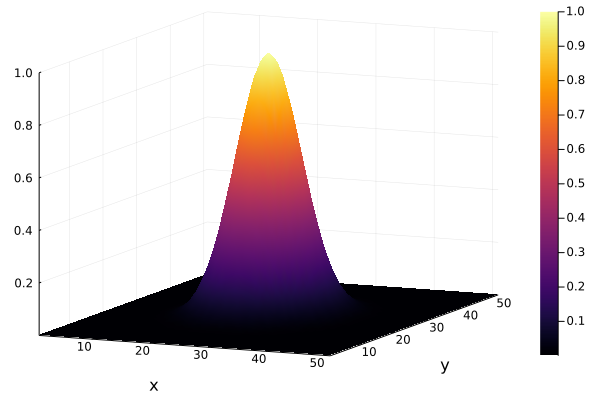

In [155]:
surface(u[:,:,1])
xlabel!("x")
ylabel!("y")

In [60]:
time_solver(u,rate,nx,ny,Δx,Δy,x,y,Δt,k,ϕ_x,[0.0,0.0],method=method,order=order,maxIT=100);

CG did not converge at time 0.0002CG did not converge at time 0.0004CG did not converge at time 0.0006000000000000001CG did not converge at time 0.0008CG did not converge at time 0.001CG did not converge at time 0.0012000000000000001CG did not converge at time 0.0014CG did not converge at time 0.0016CG did not converge at time 0.0018000000000000002CG did not converge at time 0.002CG did not converge at time 0.0022CG did not converge at time 0.0024000000000000002CG did not converge at time 0.0026000000000000003CG did not converge at time 0.0028CG did not converge at time 0.003CG did not converge at time 0.0032CG did not converge at time 0.0034000000000000002CG did not converge at time 0.0036000000000000003CG did not converge at time 0.0038CG did not converge at time 0.004CG did not converge at time 0.004200000000000001CG did not converge at time 0.0044CG did not converge at time 0.0046CG did not converge at time 0.0048000000000000004CG did not converge at time 0.005CG did not converge a

┌ Info: Saved animation to 
│   fn = c:\Users\darea\Documents\Git-stuff\SBP_operators\yes.gif
└ @ Plots C:\Users\darea\.julia\packages\Plots\9C6z9\src\animation.jl:114


Plots.AnimatedGif("c:\\Users\\darea\\Documents\\Git-stuff\\SBP_operators\\yes.gif")
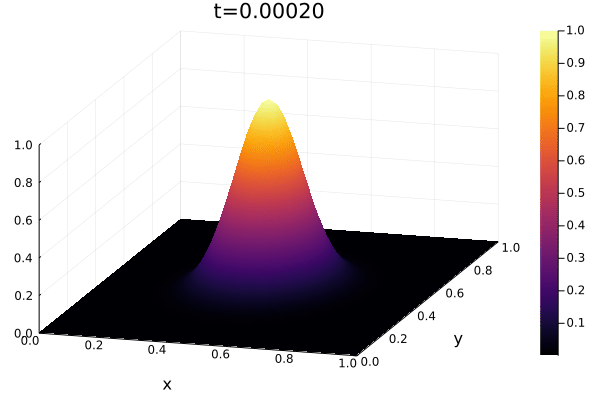

In [61]:
anim = @animate for i = 1:N
    surface(x,y,u[:,:,i],xlabel="x",ylabel="y",title="t=$(@sprintf("%.5f",i*Δt))",
        camera=(20+5*cos(1000*π*i*Δt),50),
        xlim=[0.0,1.0], ylim=[0.0,1.0], zlim=[0.0,1.0])
end

gif(anim,"yes.gif",fps=5)

┌ Info: Saved animation to 
│   fn = c:\Users\darea\Documents\Git-stuff\SBP_operators\yes.gif
└ @ Plots C:\Users\darea\.julia\packages\Plots\9C6z9\src\animation.jl:114


Plots.AnimatedGif("c:\\Users\\darea\\Documents\\Git-stuff\\SBP_operators\\yes.gif")
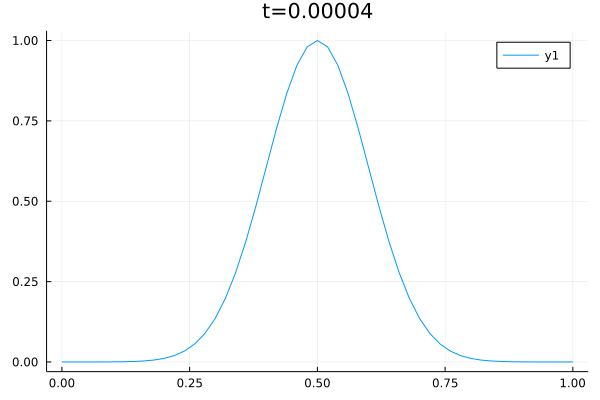

In [109]:
anim = @animate for i = 1:N
    plot(x,u[26,:,i],title="t=$(@sprintf("%.5f",i*Δt))")
end

gif(anim,"yes.gif",fps=3)

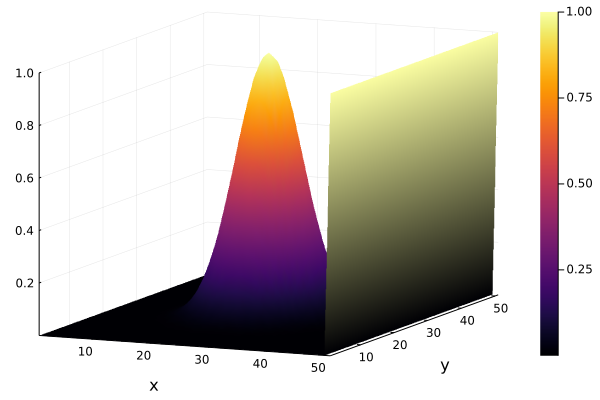

In [29]:
surface(u[:,:,end])
xlabel!("x")
ylabel!("y")